# Problème de la neige permanente
env: `phd_v3`

Une expérience clim de référence : `/thredds/idris/work/ufz23bm/IGCM_OUT/LMDZOR/PROD/clim/LMDZOR-STD-REF`

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle # For rectangles
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats # For linregress (trends)
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]
Virtual memory usage - total: 252 GB / available: 140 GB / percent used: 44.1 %


In [2]:
path = '/thredds/idris/work/ufz23bm/IGCM_OUT/LMDZOR/PROD/clim/LMDZOR-STD-REF'
period = slice('1981','1989')
latlim, lonlim = u.get_zone('HMA')

In [3]:
scf = xr.open_dataset(path+'/SRF/Analyse/TS_MO/LMDZOR-STD-REF_19800101_19891230_1M_frac_snow.nc').rename({'time_counter': 'time'}).frac_snow.sel(time=period, lat=slice(latlim.stop, latlim.start), lon=lonlim)
tas = xr.open_dataset(path+'/ATM/Analyse/TS_MO/LMDZOR-STD-REF_19800101_19891230_1M_t2m.nc').rename({'time_counter': 'time'}).t2m.sel(time=period, lat=slice(latlim.stop, latlim.start), lon=lonlim)-273.15
ta = xr.open_dataset(path+'/ATM/Analyse/TS_MO/LMDZOR-STD-REF_19800101_19891230_1M_ta.nc').rename({'time_counter': 'time'}).ta.sel(time=period, lat=slice(latlim.stop, latlim.start), lon=lonlim)-273.15
ps = xr.open_dataset(path+'/ATM/Analyse/TS_MO/LMDZOR-STD-REF_19800101_19891230_1M_psol.nc').rename({'time_counter': 'time'}).psol.sel(time=period, lat=slice(latlim.stop, latlim.start), lon=lonlim)

In [4]:
# ERA-Interim
tas_era = xr.open_mfdataset('/bdd/ERAI/NETCDF/GLOBAL_075/1xmonthly/AN_SF/*/t2.*.asmei.GLOBAL_075.nc', combine='by_coords').t2.sel(time=period, lat=slice(latlim.stop, latlim.start), lon=lonlim)-273.15
ta_era = xr.open_mfdataset('/bdd/ERAI/NETCDF/GLOBAL_075/1xmonthly/AN_PL/*/ta.*.apmei.GLOBAL_075.nc', combine='by_coords').ta.sel(time=period, lat=slice(latlim.stop, latlim.start), lon=lonlim).load()-273.15
ps_era = xr.open_mfdataset("/data/mlalande/ERAI/sp/sp_ERAI_*.nc", combine='by_coords').rename({'latitude': 'lat', 'longitude': 'lon'}).sp.sel(time=period, lat=slice(latlim.stop, latlim.start), lon=lonlim).load()

In [5]:
scf_seas = scf.groupby('time.season').mean()
tas_seas = tas.groupby('time.season').mean()
ta_seas = ta.groupby('time.season').mean()
ta_seas = ta_seas.assign_coords(plev=ta_seas.plev/100).rename({'plev': 'level'})
ps_seas = ps.groupby('time.season').mean()/100
tas_era_seas = tas_era.groupby('time.season').mean().load()
ta_era_seas = ta_era.groupby('time.season').mean()
ps_era_seas = ps_era.groupby('time.season').mean()/100

/home/mlalande/.conda/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [6]:
regridder = xe.Regridder(tas_era_seas, scf_seas, 'bilinear')
tas_era_seas_regrid = regridder(tas_era_seas)
ta_era_seas_regrid = regridder(ta_era_seas)
ps_era_seas_regrid = regridder(ps_era_seas)
ta_era_seas_regrid = ta_era_seas_regrid.where(ta_era_seas_regrid.level <= ps_era_seas_regrid)

Overwrite existing file: bilinear_40x67_24x21.nc 
 You can set reuse_weights=True to save computing time.


In [7]:
from matplotlib.patches import Rectangle # For rectangles

lat_100 = [35.492958, 29.15493, 29.15493, 38.028168]
lon_100 = [77.5, 82.5, 85.0, 97.5]
dx = 2.5
dy = 1.2676

def select_pixels(axs, lat, lon, dx, dy):
    for ax in axs:
        for i in range(len(lat)):
            ax.add_patch(
                Rectangle(
                    xy=[lon[i]-dx/2, lat[i]-dy/2], width=dx, height=dy, 
                    fill=False, color='C'+str(i), lw=2
                )
            )

/home/mlalande/.conda/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/mlalande/.conda/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


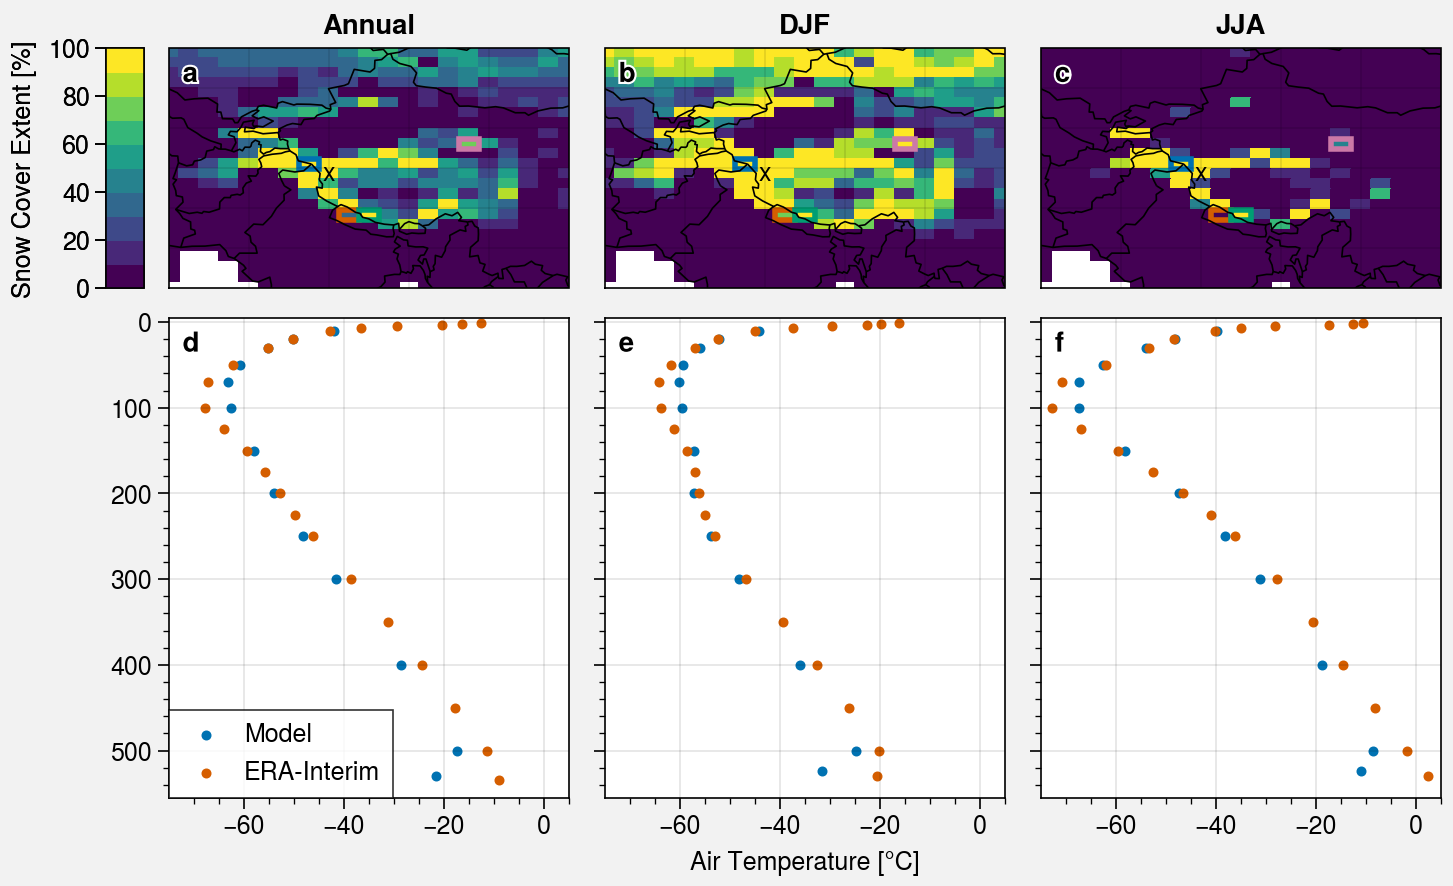

In [80]:
fig, axs = plot.subplots(ncols=3, nrows=2, proj=['cyl', 'cyl', 'cyl', None, None, None], axwidth=2, hratios=(1, 2))

cmap = 'viridis'
cmap_bias = 'RdBu'
levels = plot.arange(0, 100, 10)
lat = 34.225353
lon = 80
dx=2.5
dy=1.2676

m = axs[0].pcolormesh(scf_seas.mean('season'), cmap=cmap, levels=levels)
axs[1].pcolormesh(scf_seas.sel(season='DJF'), cmap=cmap, levels=levels)         
axs[2].pcolormesh(scf_seas.sel(season='JJA'), cmap=cmap, levels=levels)

for ax in axs[0:3]:
    ax.text(lon, lat, 'x', fontsize=9, horizontalalignment='center', verticalalignment='center')
select_pixels(axs[0:3], lat_100, lon_100, dx, dy)

fig.colorbar(m, label='Snow Cover Extent [%]', row=1, loc='l')
axs[0:3].format(
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
    labels=False, borders=True, coast=True,
)

######################################
### Profil vertical de température ###
######################################
markersize=9

h1 = axs[3].scatter(ta_seas.sel(lon=lon, lat=lat).mean('season').values, ta_seas.level.values, label='Model', markersize=markersize)
h2 = axs[3].scatter(ta_era_seas_regrid.sel(lon=lon, lat=lat).mean('season').values, ta_era_seas_regrid.level.values, label='ERA-Interim', markersize=markersize)
axs[3].scatter(tas_seas.sel(lon=lon, lat=lat).mean('season').values, ps_seas.sel(lon=lon, lat=lat).mean('season').values, color='C0', markersize=markersize)
axs[3].scatter(tas_era_seas_regrid.sel(lon=lon, lat=lat).mean('season').values, ps_era_seas_regrid.sel(lon=lon, lat=lat).mean('season').values, color='C1', markersize=markersize)

h1 = axs[4].scatter(ta_seas.sel(lon=lon, lat=lat, season='DJF').values, ta_seas.level.values, label='Model', markersize=markersize)
h2 = axs[4].scatter(ta_era_seas_regrid.sel(lon=lon, lat=lat, season='DJF').values, ta_era_seas_regrid.level.values, label='ERA-Interim', markersize=markersize)
axs[4].scatter(tas_seas.sel(lon=lon, lat=lat, season='DJF').values, ps_seas.sel(lon=lon, lat=lat, season='DJF').values, color='C0', markersize=markersize)
axs[4].scatter(tas_era_seas_regrid.sel(lon=lon, lat=lat, season='DJF').values, ps_era_seas_regrid.sel(lon=lon, lat=lat, season='DJF').values, color='C1', markersize=markersize)

h1 = axs[5].scatter(ta_seas.sel(lon=lon, lat=lat, season='JJA').values, ta_seas.level.values, label='Model', markersize=markersize)
h2 = axs[5].scatter(ta_era_seas_regrid.sel(lon=lon, lat=lat, season='JJA').values, ta_era_seas_regrid.level.values, label='ERA-Interim', markersize=markersize)
axs[5].scatter(tas_seas.sel(lon=lon, lat=lat, season='JJA').values, ps_seas.sel(lon=lon, lat=lat, season='DJF').values, color='C0', markersize=markersize)
axs[5].scatter(tas_era_seas_regrid.sel(lon=lon, lat=lat, season='JJA').values, ps_era_seas_regrid.sel(lon=lon, lat=lat, season='DJF').values, color='C1', markersize=markersize)

axs[3].legend(ncol=1)
axs[3:6].format(
    ylim=(550+5,0-5), xlim=(-75,5), 
    xlabel='Air Temperature [°C]', ylabel='Pressure level (hPa)',
)

axs.format(abc=True, abcloc='ul', collabels=['Annual', 'DJF', 'JJA'])

fig.save('img/LMDZOR-STD-REF_1981-1989_scf_ta.jpg')

## Snow related variables

In [5]:
lat_100 = [35.492958, 29.15493, 29.15493, 38.028168]
lon_100 = [77.5, 82.5, 85.0, 97.5]

In [6]:
scf = xr.open_dataset(path+'/SRF/Analyse/TS_MO/LMDZOR-STD-REF_19800101_19891230_1M_frac_snow.nc').rename({'time_counter': 'time'}).frac_snow.sel(lat=slice(latlim.stop, latlim.start), lon=lonlim)
swe = xr.open_dataset(path+'/SRF/Analyse/TS_MO/LMDZOR-STD-REF_19800101_19891230_1M_snow.nc').rename({'time_counter': 'time'}).snow.sel(lat=slice(latlim.stop, latlim.start), lon=lonlim)
sd = xr.open_dataset(path+'/SRF/Analyse/TS_MO/LMDZOR-STD-REF_19800101_19891230_1M_snowdepth.nc').rename({'time_counter': 'time'}).snowdepth.sel(lat=slice(latlim.stop, latlim.start), lon=lonlim)
melt = xr.open_dataset(path+'/SRF/Analyse/TS_MO/LMDZOR-STD-REF_19800101_19891230_1M_snowmelt.nc').rename({'time_counter': 'time'}).snowmelt.sel(lat=slice(latlim.stop, latlim.start), lon=lonlim)
melt_max = xr.open_dataset(path+'/SRF/Analyse/TS_MO/LMDZOR-STD-REF_19800101_19891230_1M_snowmelt_from_maxmass.nc').rename({'time_counter': 'time'}).snowmelt_from_maxmass.sel(lat=slice(latlim.stop, latlim.start), lon=lonlim)
tot_melt = xr.open_dataset(path+'/SRF/Analyse/TS_MO/LMDZOR-STD-REF_19800101_19891230_1M_tot_melt.nc').rename({'time_counter': 'time'}).tot_melt.sel(lat=slice(latlim.stop, latlim.start), lon=lonlim)
tair = xr.open_dataset(path+'/SRF/Analyse/TS_MO/LMDZOR-STD-REF_19800101_19891230_1M_tair.nc').rename({'time_counter': 'time'}).tair.sel(lat=slice(latlim.stop, latlim.start), lon=lonlim)-273.15
snowtemp = xr.open_dataset(path+'/SRF/Analyse/TS_MO/LMDZOR-STD-REF_19800101_19891230_1M_snowtemp_weighted.nc').rename({'time_counter': 'time'}).snowtemp_weighted.sel(lat=slice(latlim.stop, latlim.start), lon=lonlim)-273.15
subli = xr.open_dataset(path+'/SRF/Analyse/TS_MO/LMDZOR-STD-REF_19800101_19891230_1M_subli.nc').rename({'time_counter': 'time'}).subli.sel(lat=slice(latlim.stop, latlim.start), lon=lonlim)
snowf = xr.open_dataset(path+'/SRF/Analyse/TS_MO/LMDZOR-STD-REF_19800101_19891230_1M_snowf.nc').rename({'time_counter': 'time'}).snowf.sel(lat=slice(latlim.stop, latlim.start), lon=lonlim)
rain = xr.open_dataset(path+'/SRF/Analyse/TS_MO/LMDZOR-STD-REF_19800101_19891230_1M_rain.nc').rename({'time_counter': 'time'}).rain.sel(lat=slice(latlim.stop, latlim.start), lon=lonlim)
fluxlat = xr.open_dataset(path+'/SRF/Analyse/TS_MO/LMDZOR-STD-REF_19800101_19891230_1M_fluxlat.nc').rename({'time_counter': 'time'}).fluxlat.sel(lat=slice(latlim.stop, latlim.start), lon=lonlim)
fluxsens = xr.open_dataset(path+'/SRF/Analyse/TS_MO/LMDZOR-STD-REF_19800101_19891230_1M_fluxsens.nc').rename({'time_counter': 'time'}).fluxsens.sel(lat=slice(latlim.stop, latlim.start), lon=lonlim)
netrad = xr.open_dataset(path+'/SRF/Analyse/TS_MO/LMDZOR-STD-REF_19800101_19891230_1M_netrad.nc').rename({'time_counter': 'time'}).netrad.sel(lat=slice(latlim.stop, latlim.start), lon=lonlim)

### ESA snow CCI AVHRR (linear interpolation 10 days maxgap)
https://github.com/mickaellalande/PhD/blob/master/local/ESA_CCI_snow/snowCCI_preprocess_AVHRR_gricad_v1.ipynb

Mois manquant en 1994/1995 mais ok ici, commence en 1982 (donc 1 an de moins mais ok ici)

In [8]:
period

slice('1981', '1989', None)

In [14]:
root_data_path = '/data/mlalande/'
ds = xr.open_mfdataset(root_data_path+'ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/monthly_1deg/*.nc').sel(time=period, lat=latlim, lon=lonlim)
# Check if the time steps are ok
# np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, ds.time.size)
# démarre en 1982

snow_cci_interp = ds['scfg_interp_1deg_icefilled']
# snow_cci_interp = snow_cci_interp.reindex(time=pd.date_range('1982-01-31T00:00:00.000000000', '1989-12-31T00:00:00.000000000', freq='M')) # reindex to add dates from nov 1994 to jan 1995
# snow_cci_interp.load()
# snow_cci_interp.loc['1994-10'] = snow_cci_interp.loc['1994-11'].values

In [16]:
regridder = xe.Regridder(snow_cci_interp, scf, 'bilinear', periodic=False, reuse_weights=True)
snow_cci_interp_regrid = regridder(snow_cci_interp)

Create weight file: bilinear_30x50_24x21.nc


In [38]:
snow_cci_interp_regrid = snow_cci_interp_regrid.sel(time=slice('1982', '1983'))
snow_cci_interp_regrid['time'] = scf.sel(lat=lat_100[i], lon=lon_100[i], time=slice('1982', '1983')).time.values

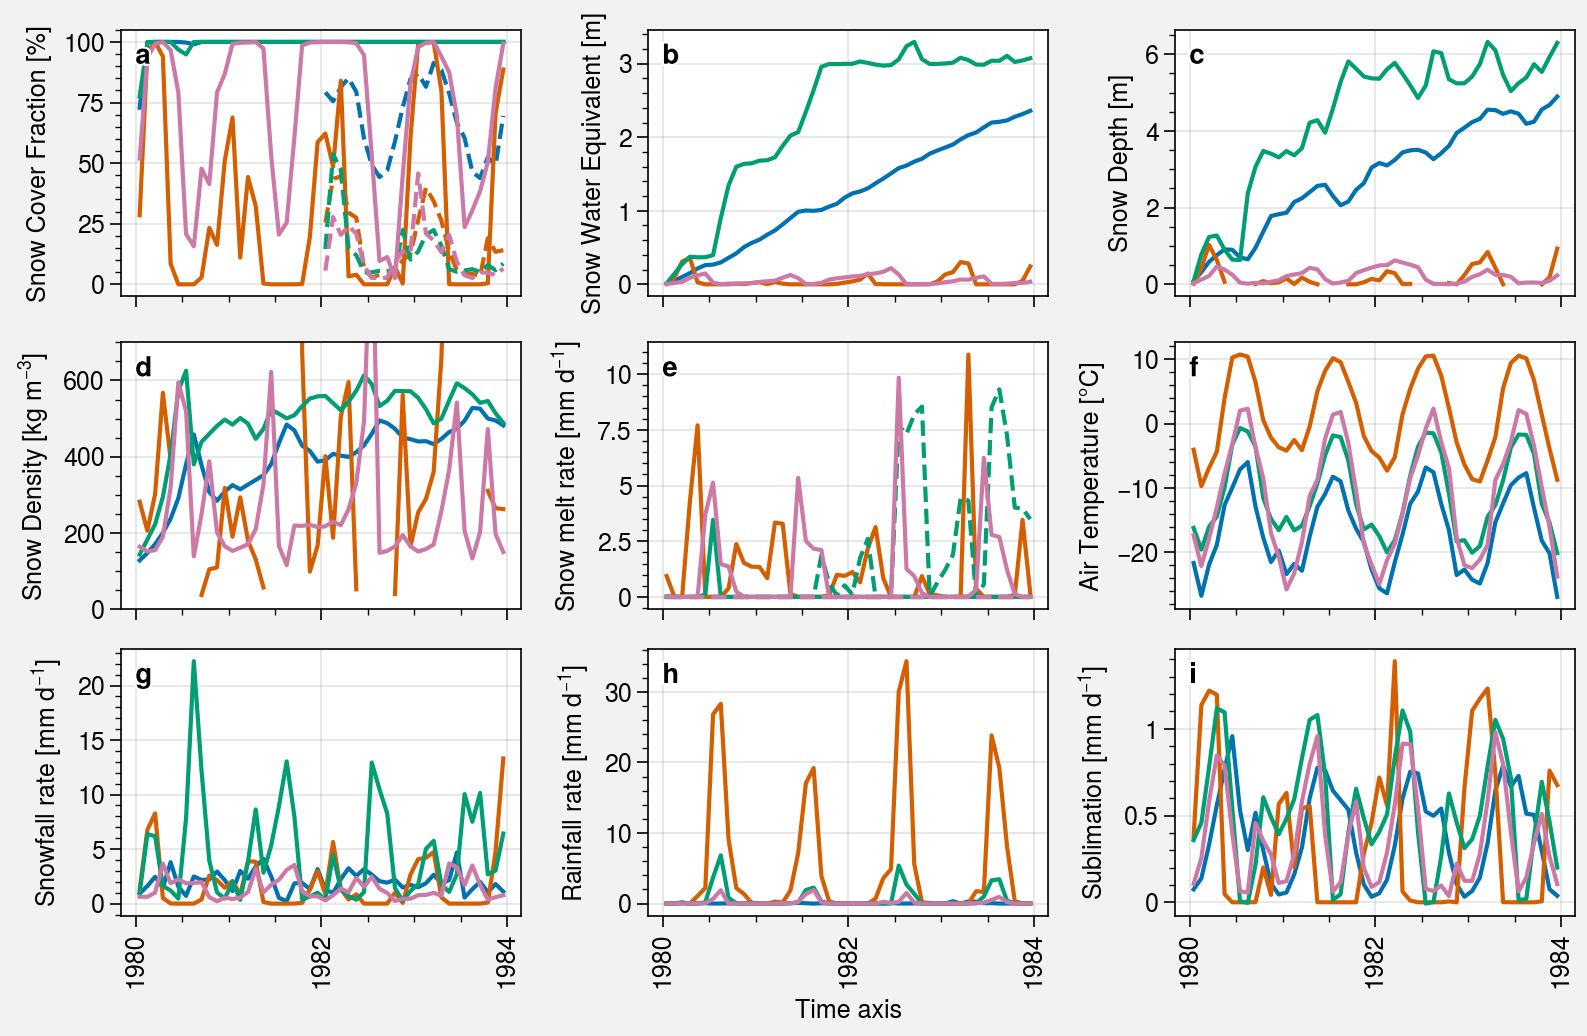

In [40]:
n = len(lat_100)
# variables = [
#     'frac_snow','snow', 'snowdepth', 
#     'snowmelt', 'snowmelt_from_maxmass', 'tot_melt',
#     'tair', 'snowtemp_weighted', 'snowage_glob', 
#     'rain', 'snowf', 'subli'
# ]

sub_period = slice('1980', '1983')
f, axs = plot.subplots(ncols=3, nrows=3, sharey=0, aspect=1.5, axwidth=2)

hs = []
for i in range(n):
    axs[0].plot(scf.sel(lat=lat_100[i], lon=lon_100[i], time=sub_period))
    axs[0].plot(snow_cci_interp_regrid.sel(lat=lat_100[i], lon=lon_100[i], time=sub_period), ls='--', color='C'+str(i))
    axs[0].format(ylabel='Snow Cover Fraction [%]')
        
    axs[1].plot((swe).sel(lat=lat_100[i], lon=lon_100[i], time=sub_period)/1000)
    axs[1].format(ylabel='Snow Water Equivalent [m]')
    
    axs[2].plot(sd.sel(lat=lat_100[i], lon=lon_100[i], time=sub_period))
    axs[2].format(ylabel='Snow Depth [m]')
    
    axs[3].plot((swe/sd).sel(lat=lat_100[i], lon=lon_100[i], time=sub_period))
    axs[3].format(ylabel='Snow Density [kg m$^{-3}$]', ylim=(0,700))
    
    axs[4].plot(melt.sel(lat=lat_100[i], lon=lon_100[i], time=sub_period)*86400)
    axs[4].format(ylabel='Snow melt rate [mm d$^{-1}$]')
    
    axs[4].plot((tot_melt-melt).sel(lat=lat_100[i], lon=lon_100[i], time=sub_period)*86400, ls='--', color='C'+str(i))
#     axs[4].format(ylabel='Tot melt [mm d$^{-1}$]')
    
    axs[5].plot(tair.sel(lat=lat_100[i], lon=lon_100[i], time=sub_period))
    axs[5].format(ylabel='Air Temperature [°C]')
    
    axs[6].plot(snowf.sel(lat=lat_100[i], lon=lon_100[i], time=sub_period))
    axs[6].format(ylabel='Snowfall rate [mm d$^{-1}$]')
    
    axs[7].plot(rain.sel(lat=lat_100[i], lon=lon_100[i], time=sub_period))
    axs[7].format(ylabel='Rainfall rate [mm d$^{-1}$]')
    
    axs[8].plot(subli.sel(lat=lat_100[i], lon=lon_100[i], time=sub_period))
    axs[8].format(ylabel='Sublimation [mm d$^{-1}$]')

    
axs.format(abc=True, abcloc='ul')

f.save('img/LMDZOR-STD-REF_1980-1983_scf_ts_SnowCCI.jpg')
